In [1]:
using Pkg
# Pkg.add("CSV")
using CSV
using PyPlot
using JuMP, Gurobi

In [8]:
soil =  CSV.read("soil data.csv")

,UniqueID,x,y,SoilType,P1_pp_Cern,OM_CernyHo,CEC_m_Cern,MG_pp_Cern
,Int64,Float64,Float64,Int64,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,1,-88.6975,42.5268,2,17.0,1.9,9.7,415.0
2,2,-88.6974,42.5268,2,17.0,1.9,9.7,415.0
3,3,-88.6973,42.5268,2,17.0,1.9,9.7,415.0
4,4,-88.6973,42.5268,2,17.0,1.9,9.7,415.0
5,5,-88.6972,42.5268,2,17.0,1.9,9.7,415.0
6,6,-88.6972,42.5268,2,17.0,1.9,9.7,415.0
7,7,-88.6971,42.5268,2,17.0,1.9,9.7,415.0
8,8,-88.6971,42.5268,2,17.0,1.9,9.7,415.0
9,9,-88.697,42.5268,2,17.0,1.9,9.7,415.0


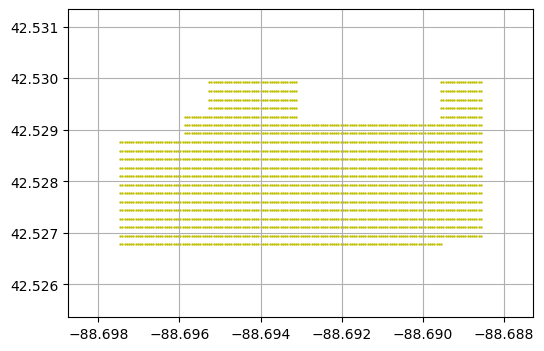

In [3]:
#onbtain all data
(num,q)=size(soil)
x = soil[1:num,2]
y = soil[1:num,3]
type11= soil[1:num,4]
type22= soil[1:num,5];

figure(figsize=(6, 4))
scatter(x,y,0.5,"y")
grid()

In [4]:
#split data
num = 308
x = soil[1:num,2]
y = soil[1:num,3]
type11= soil[1:num,4]
type22= soil[1:num,5]
type33= soil[1:num,6]
type44= soil[1:num,7]
type55= soil[1:num,8]
type66= soil[1:num,9]
type77= soil[1:num,10]
type88= soil[1:num,11]
type99= soil[1:num,12]


#normalization - this ensures all values lie in range [0,1]
type1 = (type11.-sum(type11)/num)./(maximum(type11)-minimum(type11))
type2 = (type22.-sum(type22)/num)./(maximum(type22)-minimum(type22));
type3 = (type33.-sum(type33)/num)./(maximum(type33)-minimum(type33));
type4 = (type44.-sum(type44)/num)./(maximum(type44)-minimum(type44));
type5 = (type55.-sum(type55)/num)./(maximum(type55)-minimum(type55));
type6 = (type66.-sum(type66)/num)./(maximum(type66)-minimum(type66));
type7 = (type77.-sum(type77)/num)./(maximum(type77)-minimum(type77));
type8 = (type88.-sum(type88)/num)./(maximum(type88)-minimum(type88));
type9 = (type99.-sum(type99)/num)./(maximum(type99)-minimum(type99));


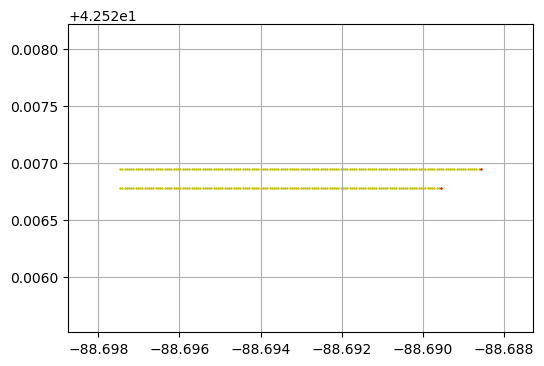

145 

In [5]:
#Find Edge points
SET = Vector{Float64}()
append!(SET, 0)
for i in 1:(num-1)
    if  x[i+1]-x[i] > 10^-4
        print(i," ");
        append!(SET, i)     
    elseif  x[i+1]-x[i] <0
         print(i," ");
        append!(SET, i)
    end
end
append!(SET, num)
#locate edge points on map
x_set = []
y_set = []
for i in 2:length(SET)
    append!(x_set, x[Int(SET[i])])
    append!(y_set, y[Int(SET[i])])
end
num_set = length(x_set)
figure(figsize=(6, 4))
scatter(x,y,0.5,"y")
scatter(x_set,y_set,0.5,"r")
grid()


## 2. Mathematical model ##
### Finding the Optimal Test Plots   ### 

$\textbf{Model type: Assignment problem}$ 

$\textbf{Parameters and Assumptions}$

For our first itteration of our problem we exluded elevation in our analysis, therefore our data exists in 2 dimensional space. set L denotes the total amount of points [1,2..,2675]. We established 2 sets N and M to denote each x and y coordinate respectfully. N contains values 1,2,..,n and M contains values 1,2..,m. To organize the different soil properties, we established a set P: [soiltype, P1, OM, CEC, MG, CA, K, BpH, pH] Laslty we established a set of chosen points, S = [1,2,3,4,5] in this itteration. 

Sets:
    L = [1,2..,2675]
    
    N = [1,2..,n]
   
    M = [1,2..,m]

    P = [soiltype, P1, OM, CEC, MG, CA, K, BpH, pH]
  
    S =[1,2,3,4,5]
   


$\textbf{Decision Variables}$ 

Our main decision variable is binary and denotes whether or not a specific coordinate is tested.    
$$
point_{i,j} = \begin{cases}
1 \text{ if point i,j is chosen }  \\
0 \text{ if point i,j is not chosen} 
\end{cases}
$$
$$for \ i \in M \ for \ j \in N$$

The next decision variable denotes the properties of the 5 test plots.  
$$pvalue_{p,s}$$ 
$$for \ p \in P \ s \in S$$

The next decision variable denotes the differences of the 9 soil properties for the chosen 5 test plots.
$$diff_{p,s}$$
$$for \ p \in P\ s \in S$$

The next decision variable denotes the maximum difference of the 9 soil properties for the 5 test plots.
$$maxdiff_{p,s}$$
$$for \ p \in P\ s \in S$$

In order to establish that each point in a test plot must be in the same row with consecutive points we need to establish neighboring variables

$$ y1_l \begin{cases}
1 \text{ if point l is chosen }  \\
0 \text{ if point l is not chosen} 
\end{cases} \forall l \in L$$

$$ y2_{s,l} \begin{cases}
1 \text{ if point l is chosen for s}  \\
0 \text{ if point l is not chosen for s} 
\end{cases} \forall s \in S, \forall l \in L$$


This last decision variable denotes each of the weighted rating of diversity for each soil property
$$obj_p$$
$$for \ p \in P\ $$

$\textbf{Constraints}$

Only 5 plots may be selected for testing
$$ \text{ } \sum_{i=1}^m point_{i,j}  = 5 \text{ } \ \forall \ j \in N $$

The difference variable must denote the difference in the soil properties 


$$ \text{ } diff_{p,s} = pvalue_{p,s}-pvalue_{p,s+1}\text{ } \ \forall p \in P, \ \forall s=1,2,..,4$$

The maxdiff variable must be the maximum difference of each soil property for each of the 5 test plots 

$$ \text{ } maxdiff_{p,s}  >= diff_{p,s} \text{ } \forall p \in P, \forall s \in S$$

Neighboring constraints:


 $$\text{ } \sum_{l=1}^L y1_l = 5  \text{ }$$
 $$\text{ } y1_l = \sum_{l=1}^L y2_{s,l} \text{ } \forall s \in S$$
 
 $$\text{ } \sum_{l=1}^L y2_{s,l} = 1 \text{ } \forall s \in S $$
 $$\text{ } \sum_{i=1}^M point_{i,j} = y1_l \text{ } \forall j \in J, \forall l \in L$$





The obj variables must denote the diversity of the test plots for each soil property
$$ \text{ } obj_p = (pvalue_{p,5}-pvalue_{p,1})+\lambda*(maxdiff_{p,s})) \text{ } \forall p  \in P, \forall s \in S$$

$\textbf{Objective}$
$$ Minimize \text{ } \sum_{j=1}^n obj_p*point_{i,j} \forall i \in M \forall p \in P$$

Academic license - for non-commercial use only
  0.079233 seconds (102.89 k allocations: 5.329 MiB)


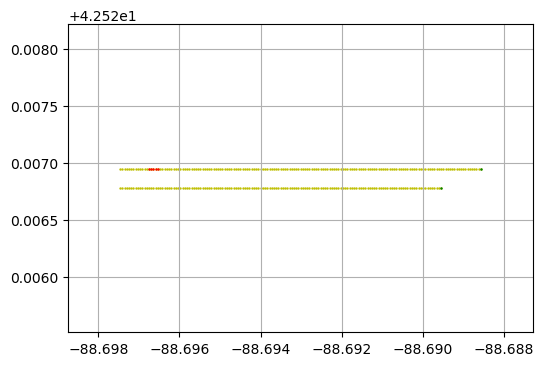

Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 8806 rows, 5034 columns and 44391 nonzeros
Model fingerprint: 0x46e7fcd4
Variable types: 1644 continuous, 3390 integer (3390 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 4948 rows and 1527 columns
Presolve time: 0.07s
Presolved: 3858 rows, 3507 columns, 18419 nonzeros
Variable types: 59 continuous, 3448 integer (3367 binary)
Found heuristic solution: objective 0.0000000

Root relaxation: objective -3.404081e+00, 3508 iterations, 0.24 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -3.40408    0   69    0.00000   -3.40408      -     -    1s
     0     0   -2.38325    0  109    0.00000   -2.38325      - 

In [6]:
#### one set - 9 objective 

#Select number of points
n_selected = 5  # total number of the points will be selected.
lambda = 10^-3  # regularization parameter

# 9 variables -  15/308 points = 93.1 seconds

####################################################################################################
Ls = Model(with_optimizer(Gurobi.Optimizer, NonConvex = 2))
@variable(Ls, point[1:n_selected,1:num], Bin)    # binary point_i_j shows if the point i will choose the plot j.
@constraint(Ls,c1,sum(point) == n_selected)      # only 10 points will be chosen.
@constraint(Ls, c2[i = 1:n_selected] , sum(point[i,:]) == 1 )   # each point must choose only one points
#################################################################################################


#################################################################################################
###L_inf regularization    #We want maximun the range of the selected point value and apply L_inf regularization 
                           #to minimize the norm of the difference.
#first variable
@variable(Ls,p_value_1[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c41[i = 1:n_selected] , p_value_1[i] == sum(type1'*point[i,:]) ) 
@constraint(Ls, c51[i = 1:n_selected-1], p_value_1[i] >= p_value_1[i+1])         # p_value is in order from large to small

@variable(Ls, diff_1[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c61[i = 1:n_selected-1], diff_1[i]==(p_value_1[i]-p_value_1[i+1]))

@variable(Ls, max_diff_1)                       # max_diff is the maximun of the difference
@constraint(Ls, c71[i = 1:n_selected-1], max_diff_1 >= diff_1[i] )      

#second variable
@variable(Ls,p_value_2[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c42[i = 1:n_selected] , p_value_2[i] == sum(type2'*point[i,:]) ) 
@constraint(Ls, c52[i = 1:n_selected-1], p_value_2[i] >= p_value_2[i+1])         # p_value is in order from large to small

@variable(Ls, diff_2[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c62[i = 1:n_selected-1], diff_2[i]==(p_value_2[i]-p_value_2[i+1]))

@variable(Ls, max_diff_2)                       # max_diff is the maximun of the difference
@constraint(Ls, c72[i = 1:n_selected-1], max_diff_2 >= diff_2[i] )   

#third variable
@variable(Ls,p_value_3[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c43[i = 1:n_selected] , p_value_3[i] == sum(type3'*point[i,:]) ) 
@constraint(Ls, c53[i = 1:n_selected-1], p_value_3[i] >= p_value_3[i+1])         # p_value is in order from large to small

@variable(Ls, diff_3[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c63[i = 1:n_selected-1], diff_3[i]==(p_value_3[i]-p_value_3[i+1]))

@variable(Ls, max_diff_3)                       # max_diff is the maximun of the difference
@constraint(Ls, c73[i = 1:n_selected-1], max_diff_3 >= diff_3[i] )   

#fourth variable
@variable(Ls,p_value_4[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c44[i = 1:n_selected] , p_value_4[i] == sum(type4'*point[i,:]) ) 
@constraint(Ls, c54[i = 1:n_selected-1], p_value_4[i] >= p_value_4[i+1])         # p_value is in order from large to small

@variable(Ls, diff_4[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c64[i = 1:n_selected-1], diff_4[i]==(p_value_4[i]-p_value_4[i+1]))

@variable(Ls, max_diff_4)                       # max_diff is the maximun of the difference
@constraint(Ls, c74[i = 1:n_selected-1], max_diff_4 >= diff_4[i] )   
#fifth variable
@variable(Ls,p_value_5[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c45[i = 1:n_selected] , p_value_5[i] == sum(type5'*point[i,:]) ) 
@constraint(Ls, c55[i = 1:n_selected-1], p_value_5[i] >= p_value_5[i+1])         # p_value is in order from large to small

@variable(Ls, diff_5[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c65[i = 1:n_selected-1], diff_5[i]==(p_value_5[i]-p_value_5[i+1]))

@variable(Ls, max_diff_5)                       # max_diff is the maximun of the difference
@constraint(Ls, c75[i = 1:n_selected-1], max_diff_5 >= diff_5[i] )   
#sixth variable
@variable(Ls,p_value_6[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c46[i = 1:n_selected] , p_value_6[i] == sum(type6'*point[i,:]) ) 
@constraint(Ls, c56[i = 1:n_selected-1], p_value_6[i] >= p_value_6[i+1])         # p_value is in order from large to small

@variable(Ls, diff_6[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c66[i = 1:n_selected-1], diff_6[i]==(p_value_6[i]-p_value_6[i+1]))

@variable(Ls, max_diff_6)                       # max_diff is the maximun of the difference
@constraint(Ls, c76[i = 1:n_selected-1], max_diff_6 >= diff_6[i] )   
#seventh variable
@variable(Ls,p_value_7[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c47[i = 1:n_selected] , p_value_7[i] == sum(type7'*point[i,:]) ) 
@constraint(Ls, c57[i = 1:n_selected-1], p_value_7[i] >= p_value_7[i+1])         # p_value is in order from large to small

@variable(Ls, diff_7[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c67[i = 1:n_selected-1], diff_7[i]==(p_value_7[i]-p_value_7[i+1]))

@variable(Ls, max_diff_7)                       # max_diff is the maximun of the difference
@constraint(Ls, c77[i = 1:n_selected-1], max_diff_7 >= diff_7[i] )   

#eighth variable
@variable(Ls,p_value_8[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c48[i = 1:n_selected] , p_value_8[i] == sum(type8'*point[i,:]) ) 
@constraint(Ls, c58[i = 1:n_selected-1], p_value_8[i] >= p_value_8[i+1])         # p_value is in order from large to small

@variable(Ls, diff_8[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c68[i = 1:n_selected-1], diff_8[i]==(p_value_8[i]-p_value_8[i+1]))

@variable(Ls, max_diff_8)                       # max_diff is the maximun of the difference
@constraint(Ls, c78[i = 1:n_selected-1], max_diff_8 >= diff_8[i] )   

#ninth variable
@variable(Ls,p_value_9[1:n_selected])           # pvalue_i is the value(property) of the point i 
@constraint(Ls, c49[i = 1:n_selected] , p_value_9[i] == sum(type9'*point[i,:]) ) 
@constraint(Ls, c59[i = 1:n_selected-1], p_value_9[i] >= p_value_9[i+1])         # p_value is in order from large to small

@variable(Ls, diff_9[1:n_selected-1])          # diff_i is the difference between the pvalue_i and pvalue_i+1
@constraint(Ls, c69[i = 1:n_selected-1], diff_9[i]==(p_value_9[i]-p_value_9[i+1]))

@variable(Ls, max_diff_9)                       # max_diff is the maximun of the difference
@constraint(Ls, c79[i = 1:n_selected-1], max_diff_9 >= diff_9[i] )   

#################################################################################################


#################################################################################################
###set constraint     #the seleceted points must be on th same line.
@variable(Ls, set[1:num_set],Bin)     # there is num_set segments(lines) in the plots, and binary set shows if the set is selected. 
@constraint(Ls,c8,sum(set)==1)   # all the points must locate in the same set.
@constraint(Ls,c9[j=1:num_set],n_selected*set[j]>=sum(sum(point[1:n_selected,(Int(SET[j]+1)):(Int(SET[j+1]))]))) 
                                # set_j equals to 1 if at least one of the points in the set_j.
#################################################################################################


#################################################################################################
###neighbor constraint   #We hope to select ten (n_selected) consecutive points
@variable(Ls, p_index[1:n_selected])        # p_index_i shows the index of the selected points 
                                            #(not with the same order of point_i)
@variable(Ls, y1[1:num],Bin)                # logical relation binary y1 shows if plot_j is selected 
@variable(Ls, y2[1:n_selected,1:num],Bin)   # logical relation binary y2 shows if point_i match with the plot_j

@constraint(Ls, cx1, sum(y1) == n_selected )                    # only 10 index equal to 1 (only 10 plots are selected)
@constraint(Ls, cx2[j=1:num], y1[j] == sum(y2[:,j]))            # if y1_j is 1, then sum_i(y2_i_j) is 1.
@constraint(Ls, cx3[i=1:n_selected], sum(y2[i,1:num]) == 1)     # each point must choose only one points
@constraint(Ls, cx4[j=1:num], sum(y2[:,j]) <= 1)                # each plots can only match at most 1 point.
@constraint(Ls, c11[j=1:num], sum(point[:,j]) == y1[j])  # logical relation shows if plot_j is not selected, y_j return 0.
#################################################################################################



#################################################################################################
#McCormick relaxation @constraint(Ls, c10[i=1:n_selected,j=1:num],(y2[i,j])*(p_index[i] - j) == 0 ) #if point_i_j located in plot_j, pindex_i equal to j.  
#w[i,j]=y2[i,j]*p_index[i]
@variable(Ls, 0<= w[i=1:n_selected,j=1:num])
@constraint(Ls, r2[i=1:n_selected,j=1:num],w[i,j]-j*y2[i,j] == 0)
@constraint(Ls, r3[i=1:n_selected,j=1:num],w[i,j] >= y2[i,j])
@constraint(Ls, r4[i=1:n_selected,j=1:num],w[i,j] >= p_index[i] + num*y2[i,j] -num)
@constraint(Ls, r5[i=1:n_selected,j=1:num],w[i,j] <= p_index[i] + y2[i,j] - 1)
@constraint(Ls, r6[i=1:n_selected,j=1:num],w[i,j] <= num*y2[i,j])

@constraint(Ls, c13[i=1:n_selected-1], p_index[i] <= p_index[i+1]-1)   # pindex is in order from large to small
@constraint(Ls, c14,p_index[n_selected] -p_index[1] <= n_selected-1)   # index_max - index_min equals to 9

#if you want more than 1 set
# @constraint(Ls, c141,p_index[Int(n_selected/3)] -p_index[1] == n_selected/3-1)   # index_max - index_min equals to 9
# @constraint(Ls, c142,p_index[Int(n_selected/3*2)] -p_index[Int(n_selected/3+1)] == n_selected/3-1)   # index_max - index_min equals to 9
# @constraint(Ls, c143,p_index[n_selected] -p_index[Int(n_selected/3*2+1)] == n_selected/3-1)   # index_max - index_min equals to 9

#################################################################################################

@variable(Ls, obj1)
@constraint(Ls, objective1, obj1 == (p_value_1[n_selected]-p_value_1[1])+lambda*(max_diff_1))

@variable(Ls, obj2)
@constraint(Ls, objective2, obj2 == (p_value_2[n_selected]-p_value_2[1])+lambda*(max_diff_2))

@variable(Ls, obj3)
@constraint(Ls, objective3, obj3 == (p_value_3[n_selected]-p_value_3[1])+lambda*(max_diff_3))

@variable(Ls, obj4)
@constraint(Ls, objective4, obj4 == (p_value_4[n_selected]-p_value_4[1])+lambda*(max_diff_4))

@variable(Ls, obj5)
@constraint(Ls, objective5, obj5 == (p_value_5[n_selected]-p_value_5[1])+lambda*(max_diff_5))

@variable(Ls, obj6)
@constraint(Ls, objective6, obj6 == (p_value_6[n_selected]-p_value_6[1])+lambda*(max_diff_6))

@variable(Ls, obj7)
@constraint(Ls, objective7, obj7 == (p_value_7[n_selected]-p_value_7[1])+lambda*(max_diff_7))

@variable(Ls, obj8)
@constraint(Ls, objective8, obj8 == (p_value_8[n_selected]-p_value_8[1])+lambda*(max_diff_8))

@variable(Ls, obj9)
@constraint(Ls, objective9, obj9 == (p_value_9[n_selected]-p_value_9[1])+lambda*(max_diff_9))


#weights for each objective if apply
a1= 1.1
#maximun the range of the selected point value(p1-p10) and apply L_inf regularization to minimize the norm of the difference.
@time @objective(Ls, Min, a1*obj1 + obj2 + obj3 + obj4 + obj5 + obj6 + obj7 + obj8 +obj9)
optimize!(Ls)



soil_val = []
p1 = []
OM = []
CEC = []
MG = []
CA = []
K = []
BpH = []
pH = []

for i in 1:n_selected
    soilv=floor(value.(p_value_1[i]*((maximum(type11)-minimum(type11)))+sum(type11)/num))
    append!(soil_val,soilv)
    p1v=floor(value.(p_value_2[i]*((maximum(type22)-minimum(type22)))+sum(type22)/num))
    append!(p1,p1v)
    OMv=floor(value.(p_value_3[i]*((maximum(type33)-minimum(type33)))+sum(type33)/num))
    append!(OM,OMv)
    CECv=floor(value.(p_value_4[i]*((maximum(type44)-minimum(type44)))+sum(type44)/num))
    append!(CEC,CECv)
    CECv=floor(value.(p_value_4[i]*((maximum(type44)-minimum(type44)))+sum(type44)/num))
    append!(CEC,CECv)
    MGv=floor(value.(p_value_5[i]*((maximum(type55)-minimum(type55)))+sum(type55)/num))
    append!(MG,MGv)
    CAv=floor(value.(p_value_6[i]*((maximum(type66)-minimum(type66)))+sum(type66)/num))
    append!(CA,CAv)
    Kv=floor(value.(p_value_7[i]*((maximum(type77)-minimum(type77)))+sum(type77)/num))
    append!(K,Kv)
    BpHv=floor(value.(p_value_8[i]*((maximum(type88)-minimum(type88)))+sum(type88)/num))
    append!(BpH,BpHv)
    pHv=floor(value.(p_value_9[i]*((maximum(type99)-minimum(type99)))+sum(type99)/num))
    append!(pH,pHv)
end


p_set = []
z_set = []
for j in 1:num
for i in 1:n_selected
    if JuMP.value(point[i,j])> 0
        println("point ",i," ID: " ,j,  "  soiltype: ",soil_val[i], "  P1: ",p1[i], "  OM: ",OM[i], 
                "  CEC: ",CEC[i], "  MG: ",MG[i], "  CA: ",CA[i],"  K: ",K[i],"  BpH: ",BpH[i],"  pH: ",pH[i])
        append!(p_set, x[j])
        append!(z_set, y[j])
    end
end
end

figure(figsize=(6, 4))
scatter(x,y,0.5,"y")
scatter(p_set,z_set,0.5,"r")
scatter(x_set,y_set,0.5,"g")
grid()